# Test notebook for Pastas parameter sensitivity analysis with PEST++ SEN Solver

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

import pastas_plugins.pest as psp

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

In [3]:
ml = ps.Model(head)
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)

In [4]:
ml_sen = ml.copy()
ml_sen.name = "Pestsen"
solver = psp.PestSenSolver(
    exe_name="bin/pestpp-sen",
    model_ws=Path("pestf_sen/model"),
    temp_ws=Path("pestf_sen/temp"),
    master_ws=Path("pestf_sen/master"),
    noptmax=1,
    port_number=4005,
)
ml_sen.solver = solver
ml_sen.solver.set_model(ml_sen)
ml_sen.solver.start()

2025-05-22 10:43:54.231677 starting: opening PstFrom.log for logging
2025-05-22 10:43:54.234961 starting PstFrom process
2025-05-22 10:43:54.235822 starting: setting up dirs
2025-05-22 10:43:54.236113 starting: removing existing new_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/temp'
2025-05-22 10:43:54.239164 finished: removing existing new_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/temp' took: 0:00:00.003051
2025-05-22 10:43:54.239406 starting: copying original_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/model' to new_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/temp'
2025-05-22 10:43:54.243253 finished: copying original_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/model' to new_d '/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/temp' took: 0:00:00.003847
2025-05-22 10:43:54.246437 finished: setting up dirs took: 0:00:00.010615
2025-05-22 10:43:54.280707 starting: adding grid type d style para

/home/martin/repos/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-05-22 10:43:54.379744 WARNING: add_py_function() command: run() is not being called directly



noptmax:0, npar_adj:3, nnz_obs:300
noptmax:1, npar_adj:3, nnz_obs:300
noptmax:1, npar_adj:3, nnz_obs:300


             pestpp-sen: a tool for global sensitivity analysis

                       by The PEST++ Development Team


version: 5.2.16
binary compiled on Dec  1 2024 at 10:51:08

started at 05/22/25 10:43:54
...processing command line: ' ./pestpp-sen pest.pst /h :4005'
...using panther run manager in master mode using port 4005

using control file: "pest.pst"
in directory: "/home/martin/repos/pastas-plugins/docs/examples/pestf_sen/temp"
on host: "VonkXPS15"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..::::::

In [5]:
df = pd.read_csv(
    ml_sen.solver.master_ws / "pest.msn", index_col="parameter_name"
).set_index(ml.parameters.index)
df.head()

,n_samples,sen_mean,sen_mean_abs,sen_std_dev
pex_A,4,-2125350.00,2125350.00,2686220.00
pex_a,4,-174948.00,174948.00,349897.00
constant_d,4,1158.04,1369.95,2072.42


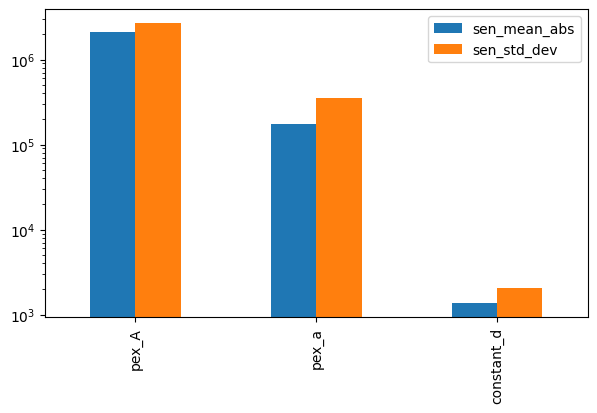

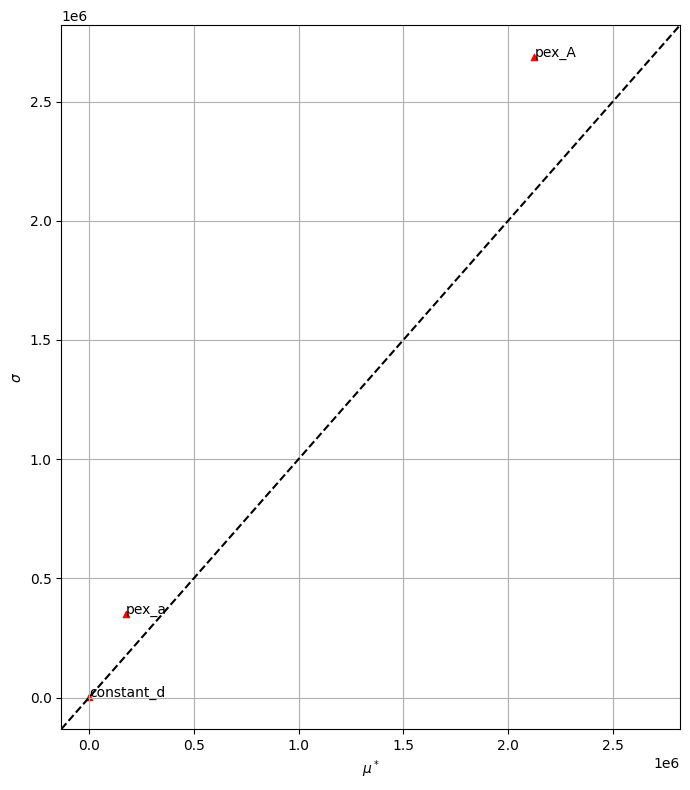

In [6]:
df = df.loc[df.sen_mean_abs > 1e-6, :]
df.loc[:, ["sen_mean_abs", "sen_std_dev"]].plot(kind="bar", figsize=(7, 4))
# ax = plt.gca()
# ax.set_ylim(1,ax.get_ylim()[1]*1.1)
plt.yscale("log")
fig, ax = plt.subplots(1, 1, figsize=(7.0, 8))
tmp_df = df
ax.scatter(tmp_df.sen_mean_abs, tmp_df.sen_std_dev, marker="^", s=20, c="r")
tmp_df = tmp_df.iloc[:8]
for x, y, n in zip(tmp_df.sen_mean_abs, tmp_df.sen_std_dev, tmp_df.index):
    ax.text(x, y, n)
mx = max(ax.get_xlim()[1], ax.get_ylim()[1])
mn = min(ax.get_xlim()[0], ax.get_ylim()[0])
ax.plot([mn, mx], [mn, mx], "k--")
ax.set_ylim(mn, mx)
ax.set_xlim(mn, mx)
ax.grid()
ax.set_ylabel("$\\sigma$")
ax.set_xlabel("$\\mu^*$")
plt.tight_layout()